In [1]:
library(glmmSeq)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



In [2]:
load('h5ad/df.fil3_gex_bcells_vdj_sce_B_switched_mem_deg.RData')
ls()

[1] "res1"     "res2"     "res3"     "res4"     "res5"     "results1"
 [7] "results2" "results3" "results4" "results5"

In [3]:
library(dplyr)
makeGeneList <- function(gl, beta_column='LFC'){
    y <- grepl('^RPS|^RPL|^MT-', row.names(gl))
    gl <- gl[!y, ]
    rank <- -log10(gl$pval) * sign(gl[,beta_column])
    rank[which(rank == Inf)] <- 300
    rank[which(rank == -Inf)] <- 300
    names(rank) <- row.names(gl)
    rank <- rev(sort(rank))
    gl <- rank
    return(gl)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
head(results1)
dim(results1)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTRNR2L8,1.4775647,0.0355570056,0.35578914,2.1285313,0,0
LINC02256,0.8730754,0.0004587874,0.01691952,0.9894142,0,0
FKBP5,0.8445720,0.0077219283,0.17456818,0.9795944,0,0
TMEM206,0.7941562,0.0008584866,0.03028343,0.8631665,0,0
AC010642.2,0.7859515,0.0044108399,0.12199982,0.8155451,0,0
BIK,0.7096255,0.0687631605,0.42385895,0.7139206,0,0


[1] 7054    6

In [5]:
head(results2)
dim(results2)

,fixed-effects estimates_linear,fixed-effects estimates_quadratic,pval,qval,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SH2D3C,0.3074558,2.783848,8.800835e-07,3.555988e-06,0,0
ARL2,0.9758432,2.650962,1.357578e-05,3.970079e-05,0,0
TMOD2,0.3852505,2.641609,6.306952e-07,2.642227e-06,0,0
ACAT2,0.4957720,2.624185,1.769308e-06,6.674531e-06,0,0
RHEX,-0.3604395,2.557852,6.600653e-05,1.597476e-04,0,0
SEL1L,-0.2786241,2.553346,2.763936e-08,1.591994e-07,0,0


[1] 4953    6

In [6]:
head(results3)
dim(results3)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDX60,1.0196690,0.0018374007,0.23414610,1.1041939,0,0
IFI6,0.9896978,0.0029606729,0.35370789,1.3077611,0,0
OAS1,0.9419629,0.0026989046,0.33829221,1.2387082,0,0
C14orf119,0.9133094,0.0087549677,0.88079583,0.9942490,0,0
HGH1,0.9020698,0.0007244789,0.09718186,0.8761787,0,0
PRDX3,0.8748592,0.0072781699,0.76231352,1.0639069,0,0


[1] 7552    6

In [7]:
head(results4)
dim(results4)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PGP,0.9718486,5.388347e-03,0.065820264,1.174584,0,0
GTF2B,0.9373836,7.050814e-03,0.082617152,1.035584,0,0
RICTOR,0.9115211,1.781142e-03,0.026123423,1.174625,0,0
WARS,0.8861998,3.627742e-02,0.294009377,1.177780,0,0
STX5,0.8610343,7.484067e-03,0.085827914,1.043728,0,0
PMAIP1,0.8567344,7.725496e-05,0.001454687,1.191307,0,0


[1] 3851    6

In [8]:
head(results5)
dim(results5)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OASL,2.314634,9.313821e-03,1.902928e-01,1.223664,0,0
ISG15,1.839672,6.892302e-06,2.576877e-04,2.514545,0,0
IFITM1,1.779922,5.070778e-89,5.067090e-87,2.513267,0,0
IFI6,1.669777,8.982164e-05,3.085373e-03,2.208110,0,0
XAF1,1.537149,1.293430e-05,4.739129e-04,2.122179,0,0
CMPK2,1.524757,2.718854e-03,7.289181e-02,1.614035,0,0


[1] 5050    6

In [9]:
library(fgsea)
library(msigdbr)

In [10]:
h <- data.frame(msigdbr::msigdbr(category = "H", species = 'Homo sapiens'))
h <- split(h, h$gs_name)
h <- lapply(h, function(x) x %>% dplyr::select(gene_symbol) %>% unlist %>% as.character)

In [64]:
plotGSEA_Hallmark <- function(gsea, fdr_cutoff = 0.05, cols = NULL, xlim = NULL, newlabels = NULL, keep_significant_only = TRUE, jitter = FALSE) {
    require(ggplot2)
    gsea$NES[which(is.na(gsea$NES))] <- 0
    gsea$pval[which(is.na(gsea$pval))] <- 1
    gsea$padj[which(is.na(gsea$padj))] <- 1
    gsea$ranking[which(is.na(gsea$ranking))] <- 0
    gsea <- gsea[order(gsea$ranking),]
    
    if (keep_significant_only){
        gseax <- split(gsea, gsea$pathway)
        for (i in 1:length(gseax)){
            if (all(gseax[[i]]$pval >= 0.05)|all(gseax[[i]]$padj >=fdr_cutoff)){
                gseax[[i]] <- NA        
            }
        }
        gseax <- gseax[!is.na(gseax)]
        gsea <- do.call(rbind, gseax)        
    }
    if (!is.null(gsea)){
        gsea <- gsea[order(gsea$ranking), ]
        gsea$pathway <- gsub("HALLMARK_|", "", gsea$pathway)

        if (!is.null(xlim)){
            x_lim_min = -xlim
            x_lim_max = xlim
        } else {
            x_lim_min <- abs(ceiling(min(-log10(gsea$padj))))
            x_lim_max <- abs(ceiling(max(-log10(gsea$padj))))
        }
        
        if(x_lim_min > x_lim_max){
            xval1 <- x_lim_min * -1
            xval2 <- x_lim_min
        } else {
            xval1 <- x_lim_max * -1
            xval2 <- x_lim_max
        }

        if(!is.null(cols)){
            gg_color_hue <- function(n) {
                hues = seq(15, 375, length = n + 1)
                hcl(h = hues, l = 65, c = 100)[1:n]
            }
            cols. = gg_color_hue(dplyr::n_distinct(gsea$group, na.rm = TRUE))
        } else {
            cols. = cols
        }    
    
        g <- ggplot(gsea, aes(x = -log10(padj)*sign(NES), y = reorder(pathway, ranking), col = -log10(padj)*sign(NES), size = abs(NES)))
        if (jitter){
            g <- g + geom_point(position = 'jitter')
        }else{
            g <- g + geom_point()
        }
        g <- g + theme_bw() +
            labs(x = expression(paste("Signed", " -log" ["10"], "adjusted pval")), y = "Hallmarks") +
            scale_color_gradient2(low = '#2166ac', mid = '#f7f7f7', high = '#b2182b', na.value = NA, limits = c(-2,2), oob = scales::squish) +
            geom_vline(xintercept = 0) +
            geom_vline(xintercept = -log10(fdr_cutoff), colour = '#ff7f0e') +
            geom_vline(xintercept = -log10(fdr_cutoff)*-1, colour = '#ff7f0e') +
            scale_x_continuous(limits = c(xval1, xval2), oob = scales::squish) +
            scale_size_area(oob = scales::squish, max_size = 3, limits = c(0,2)) +
            theme(panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(), 
                panel.background = element_blank(), 
                axis.line = element_blank(), 
                axis.ticks = element_blank(),
                axis.text = element_text(color = 'black'),
                axis.title = element_text(color = 'black'),
                legend.direction = "vertical", legend.box = "horizontal"
                )
        
        return(g)
    }
}

Warning message in fgseaMultilevel(...):
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


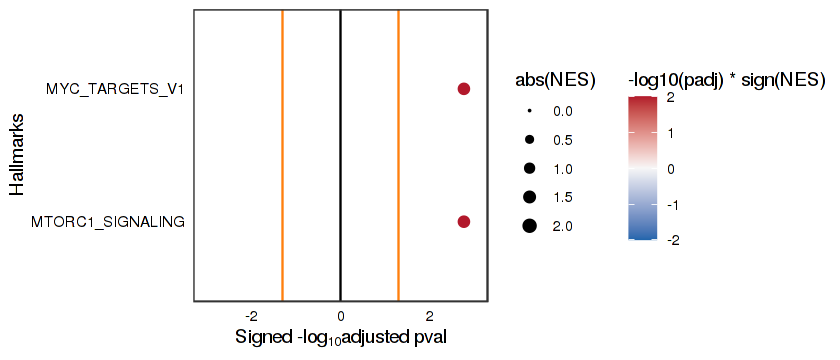

In [65]:
options(repr.plot.height = 3)
gl1 <- makeGeneList(results1)
res1gsea <- fgsea(pathways = h, stats = gl1, minSize = 0, maxSize =1000)
res1gsea$ranking <- -log10(res1gsea$pval) * sign(res1gsea$NES)
plotGSEA_Hallmark(res1gsea)

In [66]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_linear')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

In [67]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_quadratic')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

Warning message in fgseaMultilevel(...):
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


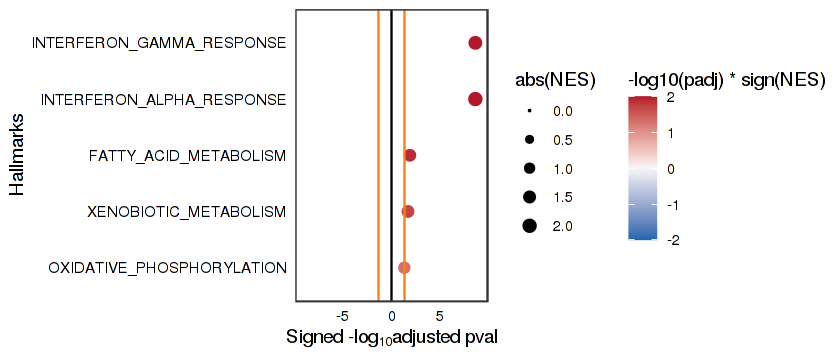

In [68]:
options(repr.plot.height = 3)
gl3 <- makeGeneList(results3)
res3gsea <- fgsea(pathways = h, stats = gl3, minSize = 0, maxSize =1000)
res3gsea$ranking <- -log10(res3gsea$pval) * sign(res3gsea$NES)
plotGSEA_Hallmark(res3gsea)

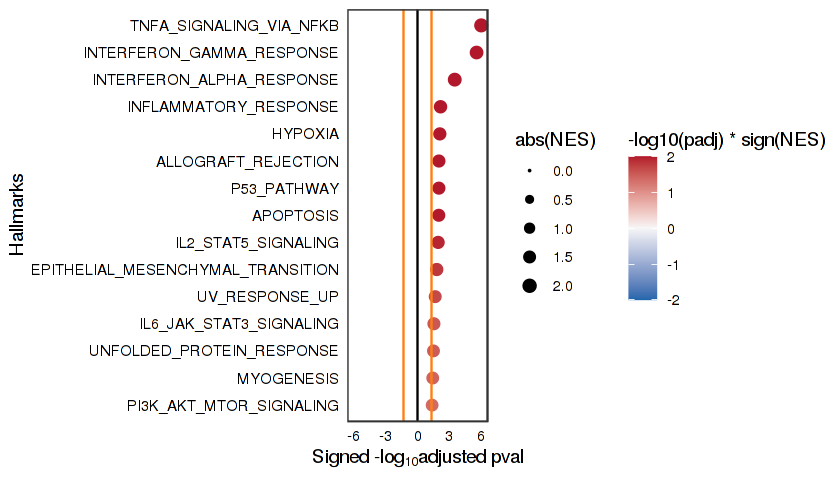

In [69]:
options(repr.plot.height = 4)
gl4 <- makeGeneList(results4)
res4gsea <- fgsea(pathways = h, stats = gl4, minSize = 0, maxSize =1000)
res4gsea$ranking <- -log10(res4gsea$pval) * sign(res4gsea$NES)
plotGSEA_Hallmark(res4gsea)

In [71]:
res4gsea %>% filter(pathway %in% c('HALLMARK_TNFA_SIGNALING_VIA_NFKB'))

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,ranking
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.084632e-08,1.042316e-06,0.733762,0.7318723,1.890507,66,"DUSP1 , JUN , JUNB , KLF6 , PPP1R15A, KLF2 , SAT1 , IRF1 , NFKBIA , CD69 , BTG1 , ZFP36 , CD83 , SLC2A3 , IER5 , NR4A2 , MARCKS , NFKB1 , TNIP1 , NFKB2 , IFIH1 , PDE4B , RHOB , MCL1 , SQSTM1 , CCNL1 , REL , FOS",7.680971


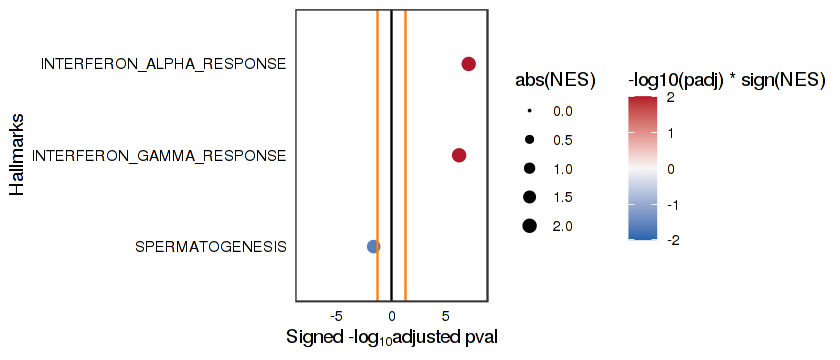

In [70]:
options(repr.plot.height = 3)
gl5 <- makeGeneList(results5)
res5gsea <- fgsea(pathways = h, stats = gl5, minSize = 0, maxSize =1000)
res5gsea$ranking <- -log10(res5gsea$pval) * sign(res5gsea$NES)
plotGSEA_Hallmark(res5gsea)